### ML FM Project
#### Muhammad Abeer Khan

STEP 1: Imports + Loading the dataset from Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/nvidia_stock_prices.csv")
# Basic cleanup
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(df.head())
print(df.shape)


        Date      Open      High       Low     Close      Volume
0 2004-01-02  0.196417  0.199083  0.192333  0.192333   436416000
1 2004-01-05  0.195250  0.199917  0.193500  0.198583   575292000
2 2004-01-06  0.198000  0.209417  0.197083  0.206667  1093344000
3 2004-01-07  0.204333  0.209500  0.202917  0.208500   673032000
4 2004-01-08  0.211083  0.212083  0.207250  0.209250   433752000
(5033, 6)


STEP 2: Creating the main time series (Close) + returns

In [6]:
df["Close"] = df["Close"].astype(float)

# Daily returns (percentage change)
df["ret"] = df["Close"].pct_change()

# Log price (helps trend slope behave nicely)
df["log_close"] = np.log(df["Close"])

df[["Date", "Close", "ret"]].head()


,Date,Close,ret
0,2004-01-02,0.192333,NaN
1,2004-01-05,0.198583,0.032496
2,2004-01-06,0.206667,0.040708
3,2004-01-07,0.208500,0.008869
4,2004-01-08,0.209250,0.003597


STEP 3: Computing Metrics: Trend (slope) + Volatility

In [7]:
W_trend = 20
W_vol = 20

def rolling_slope(arr):
    x = np.arange(len(arr), dtype=float)
    return np.polyfit(x, arr, 1)[0]   # slope

# Trend slope of log price
df["trend"] = df["log_close"].rolling(W_trend).apply(rolling_slope, raw=True)

# Trend direction (+1 upward, -1 downward, 0 flat/unknown)
df["trend_dir"] = np.sign(df["trend"])

# Trend magnitude
df["abs_trend"] = df["trend"].abs()

# Volatility (rolling std of returns)
df["vol"] = df["ret"].rolling(W_vol).std()

df[["Date", "Close", "trend", "trend_dir", "abs_trend", "vol"]].tail()


,Date,Close,trend,trend_dir,abs_trend,vol
5028,2023-12-22,48.830002,0.002543,1.0,0.002543,0.018817
5029,2023-12-26,49.278999,0.003176,1.0,0.003176,0.018804
5030,2023-12-27,49.417000,0.003679,1.0,0.003679,0.018659
5031,2023-12-28,49.521999,0.004268,1.0,0.004268,0.018624
5032,2023-12-29,49.521999,0.004358,1.0,0.004358,0.017245


STEP 4: Shock detection (Alert)

In [8]:
k = 2.0

# Use previous day's volatility to avoid "today influencing today's threshold"
df["vol_prev"] = df["vol"].shift(1)

df["shock"] = df["ret"].abs() > k * df["vol_prev"]

df[["Date", "ret", "vol", "vol_prev", "shock"]].tail()


,Date,ret,vol,vol_prev,shock
5028,2023-12-22,-0.003266,0.018817,0.019354,False
5029,2023-12-26,0.009195,0.018804,0.018817,False
5030,2023-12-27,0.002800,0.018659,0.018804,False
5031,2023-12-28,0.002125,0.018624,0.018659,False
5032,2023-12-29,0.000000,0.017245,0.018624,False


STEP 5: Choosing thresholds (data-driven, industry style)

In [9]:
min_hist = 60  # need some past history before thresholds become valid

df["vol_low_t"]  = df["vol"].expanding(min_periods=min_hist).quantile(0.25).shift(1)
df["vol_high_t"] = df["vol"].expanding(min_periods=min_hist).quantile(0.75).shift(1)

df["trend_small_t"] = df["abs_trend"].expanding(min_periods=min_hist).quantile(0.25).shift(1)
df["trend_big_t"]   = df["abs_trend"].expanding(min_periods=min_hist).quantile(0.75).shift(1)

df[["Date", "vol", "vol_low_t", "vol_high_t", "abs_trend", "trend_small_t", "trend_big_t"]].tail()


,Date,vol,vol_low_t,vol_high_t,abs_trend,trend_small_t,trend_big_t
5028,2023-12-22,0.018817,0.018919,0.034088,0.002543,0.002032,0.008005
5029,2023-12-26,0.018804,0.018915,0.034087,0.003176,0.002032,0.008004
5030,2023-12-27,0.018659,0.018910,0.034085,0.003679,0.002032,0.008003
5031,2023-12-28,0.018624,0.018908,0.034083,0.004268,0.002032,0.008002
5032,2023-12-29,0.017245,0.018906,0.034081,0.004358,0.002032,0.008001


STEP 6: Define Feeling States (rule-based mapping)

In [10]:

def map_feeling(row):
    needed = [
        "ret", "vol", "abs_trend", "trend_dir",
        "vol_low_t", "vol_high_t", "trend_small_t", "trend_big_t",
        "shock"
    ]
    if any(pd.isna(row[c]) for c in needed):
        return np.nan

    v = row["vol"]
    abs_tr = row["abs_trend"]
    dir_ = row["trend_dir"]

    v_low = row["vol_low_t"]
    v_high = row["vol_high_t"]
    s_small = row["trend_small_t"]
    s_big = row["trend_big_t"]

    # 1) Alert (shock) — highest priority
    if bool(row["shock"]):
        return "Alert"

    # 2) Excitement (direction-aware): strong trend + high volatility
    if abs_tr > s_big and v > v_high:
        return "Excitement_Up" if dir_ > 0 else "Excitement_Down"

    # 3) Stress: high volatility + weak trend
    if v > v_high and abs_tr <= s_small:
        return "Stress"

    # 4) Calm: low volatility + weak trend
    if v <= v_low and abs_tr <= s_small:
        return "Calm"

    return "Neutral"

df["feeling"] = df.apply(map_feeling, axis=1)

df[["Date", "Close", "ret", "trend", "vol", "shock", "feeling"]].tail(20)


,Date,Close,ret,trend,vol,shock,feeling
5013,2023-12-01,46.764999,-0.000107,0.001856,0.017470,False,Calm
5014,2023-12-04,45.509998,-0.026836,0.000120,0.017177,False,Calm
5015,2023-12-05,46.566002,0.023204,-0.001045,0.017559,False,Calm
5016,2023-12-06,45.502998,-0.022828,-0.002497,0.018322,False,Neutral
5017,2023-12-07,46.596001,0.024020,-0.003383,0.018883,False,Neutral
5018,2023-12-08,47.506001,0.019530,-0.003867,0.019304,False,Neutral
5019,2023-12-11,46.626999,-0.018503,-0.004176,0.018511,False,Neutral
5020,2023-12-12,47.657001,0.022090,-0.004027,0.019200,False,Neutral
5021,2023-12-13,48.088001,0.009044,-0.003385,0.018643,False,Neutral
5022,2023-12-14,48.349998,0.005448,-0.002864,0.018400,False,Neutral


STEP 7: Output 1 Timeline of feelings (price chart + colored points)

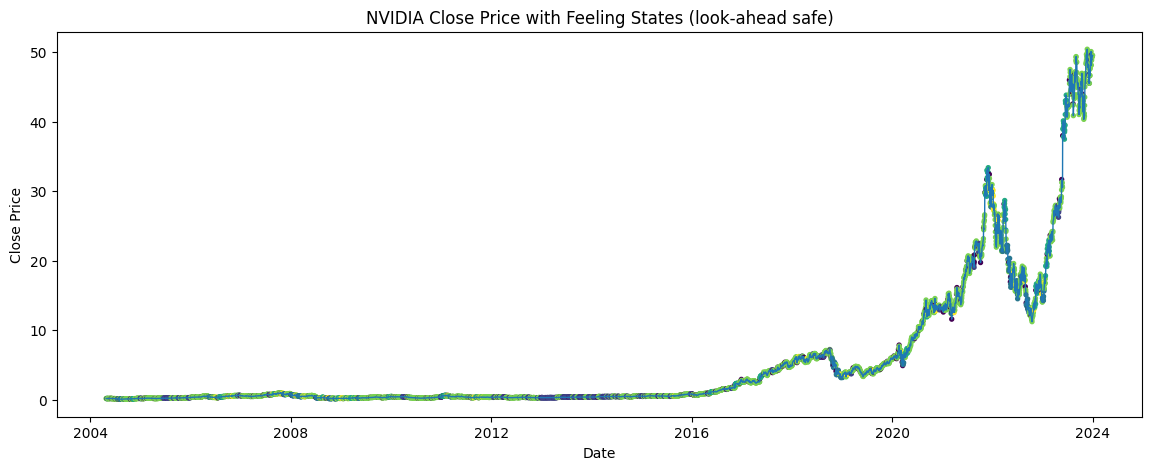

Feeling labels: ['Alert', 'Calm', 'Excitement_Down', 'Excitement_Up', 'Neutral', 'Stress']


In [11]:

plot_df = df.dropna(subset=["feeling"]).copy()

feelings_cat = plot_df["feeling"].astype("category")
codes = feelings_cat.cat.codes

plt.figure(figsize=(14,5))
plt.plot(plot_df["Date"], plot_df["Close"], linewidth=1)
plt.scatter(plot_df["Date"], plot_df["Close"], c=codes, s=8)
plt.title("NVIDIA Close Price with Feeling States (look-ahead safe)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

print("Feeling labels:", list(feelings_cat.cat.categories))


STEP 8: Output 2: Pie chart of feeling distribution

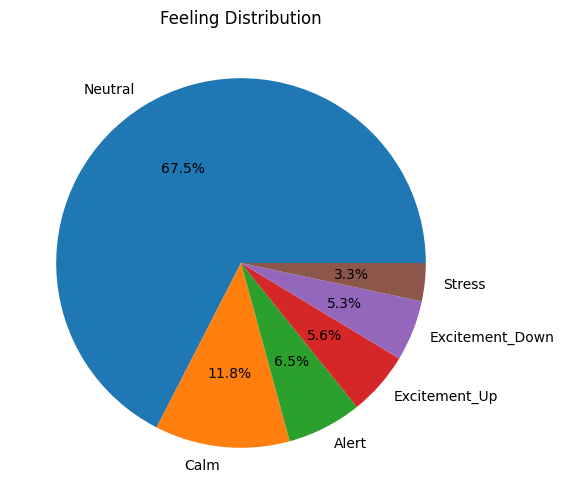

,count
feeling,
Neutral,3341
Calm,584
Alert,324
Excitement_Up,276
Excitement_Down,263
Stress,165


In [12]:

dist = plot_df["feeling"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(dist.values, labels=dist.index, autopct="%1.1f%%")
plt.title("Feeling Distribution")
plt.show()

dist


STEP 9: Output 3: Transition matrix between feelings

Transition counts:


,Alert,Calm,Excitement_Down,Excitement_Up,Neutral,Stress
Alert,22,35,25,17,214,11
Calm,56,479,0,0,49,0
Excitement_Down,11,0,218,0,34,0
Excitement_Up,7,0,0,224,45,0
Neutral,224,70,20,35,2943,48
Stress,4,0,0,0,55,106



Transition probabilities (row-normalized):


,Alert,Calm,Excitement_Down,Excitement_Up,Neutral,Stress
Alert,0.067901,0.108025,0.077160,0.052469,0.660494,0.033951
Calm,0.095890,0.820205,0.000000,0.000000,0.083904,0.000000
Excitement_Down,0.041825,0.000000,0.828897,0.000000,0.129278,0.000000
Excitement_Up,0.025362,0.000000,0.000000,0.811594,0.163043,0.000000
Neutral,0.067066,0.020958,0.005988,0.010479,0.881138,0.014371
Stress,0.024242,0.000000,0.000000,0.000000,0.333333,0.642424


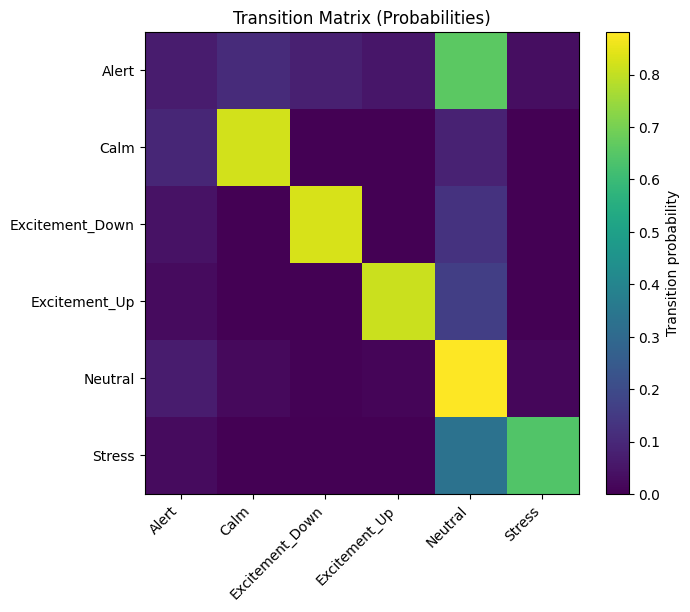

In [13]:

seq = plot_df["feeling"].tolist()

states = sorted(plot_df["feeling"].unique())
state_to_idx = {s:i for i,s in enumerate(states)}
n = len(states)

Tmat = np.zeros((n, n), dtype=int)
for a, b in zip(seq[:-1], seq[1:]):
    Tmat[state_to_idx[a], state_to_idx[b]] += 1

row_sums = Tmat.sum(axis=1, keepdims=True)
Tprob = np.divide(Tmat, row_sums, out=np.zeros_like(Tmat, dtype=float), where=row_sums!=0)

Tcount_df = pd.DataFrame(Tmat, index=states, columns=states)
Tprob_df = pd.DataFrame(Tprob, index=states, columns=states)

print("Transition counts:")
display(Tcount_df)

print("\nTransition probabilities (row-normalized):")
display(Tprob_df)

plt.figure(figsize=(7,6))
plt.imshow(Tprob, aspect="auto")
plt.xticks(range(n), states, rotation=45, ha="right")
plt.yticks(range(n), states)
plt.colorbar(label="Transition probability")
plt.title("Transition Matrix (Probabilities)")
plt.show()


The project implements a rule-based Feeling Machine on stock time-series data with causal thresholds, trend direction awareness, and interpretable affective state dynamics.